<a href="https://colab.research.google.com/github/mesogin/TIS2/blob/main/9_2_%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9C%BC%EB%A1%9C_IMDB_%EB%A6%AC%EB%B7%B0_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 순환 신경망으로 IMDB 리뷰 분류하기

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [2]:
from tensorflow.keras.datasets import imdb

# 전체 데이터셋에서 가장 자주 등장하는 500개의 단어만 사용(num_words=500)
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

In [3]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [4]:
# 각 리뷰의 길이를 조사해 넘파이 배열에 담음
# 리스트 내포를 사용

import numpy as np

lengths = np.array([len(x) for x in train_input])

In [5]:
# 리뷰 길이의 평균과 중간값
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


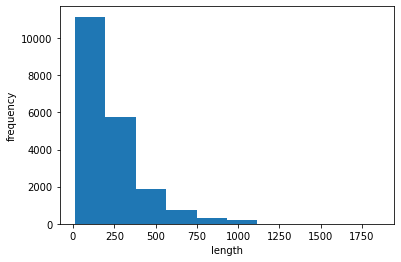

In [6]:
# 히스토그램으로 리뷰 길이의 분포 확인
# 대부분의 길이는 300 미만

import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [7]:
# pad_sequences() 함수를 사용해 train_input의 길이를 100으로 맞춤
# 100이 넘어가는경우 뒤에서 100개로 맞춰 앞에를 자름
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

In [8]:
# 여섯 번째 샘플 출력

print(train_seq[5])
#앞부분에 0이 있는 것으로 보아 샘플의 길이는 100이 안됨.

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [9]:
# 검증세트의 길이도 100으로 맞추어 줌
val_seq = pad_sequences(val_input, maxlen=100)

##순환 신경망 만들기

In [10]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500))) #input길이 100, 각각의 단어들은 500의 다른 숫자로 설명함
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [11]:
# train_seq를 원핫 인코딩으로 변환하여 train_oh 배열을 만듦

train_oh = keras.utils.to_categorical(train_seq)

In [12]:
# 배열의 크기 출력

print(train_oh.shape)
#정수 하나마다 모두 500차원의 배열로 변경해서 (20000, 100) -> (20000, 100, 500)으로 변경

(20000, 100, 500)


In [13]:
#val_seq도 원-핫 인코딩으로 변환
val_oh = keras.utils.to_categorical(val_seq)

In [14]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [15]:
#램 초과함
# rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
# model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
#               metrics=['accuracy'])

# checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', 
#                                                 save_best_only=True)
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
#                                                   restore_best_weights=True)

# history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
#                     validation_data=(val_oh, val_target),
#                     callbacks=[checkpoint_cb, early_stopping_cb])


In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend(['train', 'val'])
# plt.show()

In [16]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [17]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [18]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 14s 37ms/step - loss: 0.6850 - accuracy: 0.5497 - val_loss: 0.6598 - val_accuracy: 0.6104
Epoch 2/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6230 - accuracy: 0.6680 - val_loss: 0.6020 - val_accuracy: 0.6938
Epoch 3/100
313/313 [==============================] - 10s 32ms/step - loss: 0.5715 - accuracy: 0.7286 - val_loss: 0.5643 - val_accuracy: 0.7354
Epoch 4/100
313/313 [==============================] - 10s 32ms/step - loss: 0.5380 - accuracy: 0.7539 - val_loss: 0.5428 - val_accuracy: 0.7378
Epoch 5/100
313/313 [==============================] - 8s 25ms/step - loss: 0.5176 - accuracy: 0.7654 - val_loss: 0.5224 - val_accuracy: 0.7544
Epoch 6/100
313/313 [==============================] - 10s 32ms/step - loss: 0.5046 - accuracy: 0.7713 - val_loss: 0.5167 - val_accuracy: 0.7534
Epoch 7/100
313/313 [==============================] - 9s 27ms/step - loss: 0.4937 - accuracy: 0.7770 - val_loss: 0.5055 - val_accur

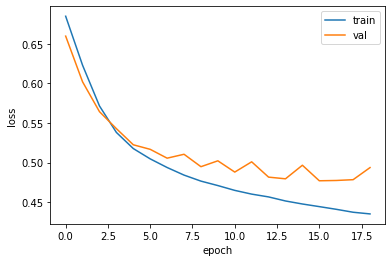

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()